In [29]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
import math
from IPython.display import display, clear_output
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter

## need to pip install this to read in images, not necessary except for last cell
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# set random seed to achieve same results each time
np.random.seed(23)

### Object to Hold Our Training, Dev and Test Data as Well as Simple Methods to Preprocess Data

In [30]:
class FacialKeypoints(object):
    
    def __init__(self):
        self.train_csv = pd.read_csv("training.csv")
        self.test_csv = pd.read_csv("test.csv")
        self.sample_csv = pd.read_csv("SampleSubmission.csv")
        self.ID_csv = pd.read_csv("IdLookupTable.csv")
        self.label_names = self.train_csv.columns.tolist()[:-1]
        self.dev_data_n, self.dev_labels_n, self.train_data_n, self.train_labels_n = self.create_training(self.train_csv)
        self.dev_data, self.dev_labels, self.train_data, self.train_labels = self.create_training(self.train_csv, nans=False)
        self.train_data_f, self.train_labels_f = self.flip_data(self.train_data), self.flip_labels(self.train_labels)
        self.test_data, _ = self._parse_data(self.test_csv)
    
    def create_training(self, train_csv, dev_size=1000, nans=True):
        if nans == False:
            train_csv = train_csv.dropna()
        data, labels = self._parse_data(train_csv)
        shuffle = np.random.permutation(np.arange(data.shape[0]))        
        data, labels              = data[shuffle], labels[shuffle]       # Shuffle the data
        dev_data, dev_labels      = data[:dev_size], labels[:dev_size]   # Splitting into dev and training
        train_data, train_labels  = data[dev_size:], labels[dev_size:]
        return dev_data, dev_labels, train_data, train_labels
    
    def plot_example(self, data, label, predicted_label=np.nan, legend=True):
        plt.imshow(data.reshape(96, 96), cmap='gray')
        plt.scatter(label[0::2], label[1::2], c='red', marker='x', label='actual')
        if np.all(np.isfinite(predicted_label)):
            plt.scatter(predicted_label[0::2], predicted_label[1::2], c='blue', marker='x', label='predicted')
        plt.axis('off')
        if legend:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        return
    
    def score(self, y_pred, y_actual):
        return np.sqrt(mean_squared_error(y_actual, y_pred))
    
    def blur_data(self, data):
        data = data.reshape(data.shape[0], int(data.shape[1]**0.5), -1) 
        data = np.array([np.roll(np.roll(data, horizontal, axis=1), 
                                               vertical  , axis=2) 
                         for vertical in range(-1,2) for horizontal in range(-1,2)]
                       ).mean(axis=0)     
        return data.reshape(data.shape[0], -1)
    
    def submission_gen(self, predictions, file_name):
        df = pd.DataFrame(predictions, columns=self.train_csv.columns[:-1])
        pos = []
        for index, row in self.ID_csv.iterrows():
            pos.append((row['RowId'], df.iloc[row.ImageId - 1][row.FeatureName]))
        sub = pd.DataFrame(pos, columns=('RowId', 'Location'))
        sub.to_csv("./" + file_name + ".csv", index=False)
        return
    
    ## Various Methods to Create More Training Examples
    def average_nans(self, train_labels):
        df = pd.DataFrame(train_labels)
        return df.fillna(df.mean()).values
    
    def flip_data(self, train_data):
        num_images = train_data.shape[0]
        train_data = train_data.reshape(num_images, 96, 96)[..., ::-1].flatten()
        return train_data.reshape(num_images, 9216)
    
    def flip_labels(self, train_labels):
        df = pd.DataFrame(train_labels.copy(), columns=self.label_names)
        df.loc[:, df.columns.str.contains('_x')] = df.loc[:, df.columns.str.contains('_x')].applymap(self._flip_axis)
        return df.values
        
    ## Helper Functions
    def _flip_axis(self, value, axis=47):
        if value >= axis:
            return axis - np.abs(value - axis)
        else:
            return axis + np.abs(value - axis)
    
    def _parse_data(self, data):
        labels = data.loc[:, data.columns != 'Image'].values   # column Image is the image data
        data = data['Image'].str.split()                       # image data comes as one long string
        data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
        data = data/255.0                                      # Rescale grayscale values to [0,1].
        return data, labels
    
    def rgb2gray(self, rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray
    
    pass

## Initialize the Object

In [31]:
self = FacialKeypoints()

## Missing Labels

We noticed that there are many examples that are missing a full label set. Out of the total 6049 examples, only 1140 have the full set of labels. Here is the percentage break out of each label

In [13]:
(self.train_csv.loc[:, self.train_csv.columns != 'Image'].count()/len(self.train_csv.index)).round(3)

left_eye_center_x            0.999
left_eye_center_y            0.999
right_eye_center_x           0.998
right_eye_center_y           0.998
left_eye_inner_corner_x      0.322
left_eye_inner_corner_y      0.322
left_eye_outer_corner_x      0.322
left_eye_outer_corner_y      0.322
right_eye_inner_corner_x     0.322
right_eye_inner_corner_y     0.322
right_eye_outer_corner_x     0.322
right_eye_outer_corner_y     0.322
left_eyebrow_inner_end_x     0.322
left_eyebrow_inner_end_y     0.322
left_eyebrow_outer_end_x     0.316
left_eyebrow_outer_end_y     0.316
right_eyebrow_inner_end_x    0.322
right_eyebrow_inner_end_y    0.322
right_eyebrow_outer_end_x    0.317
right_eyebrow_outer_end_y    0.317
nose_tip_x                   1.000
nose_tip_y                   1.000
mouth_left_corner_x          0.322
mouth_left_corner_y          0.322
mouth_right_corner_x         0.322
mouth_right_corner_y         0.322
mouth_center_top_lip_x       0.323
mouth_center_top_lip_y       0.323
mouth_center_bottom_

#### Plot Examples From Incomplete Labels

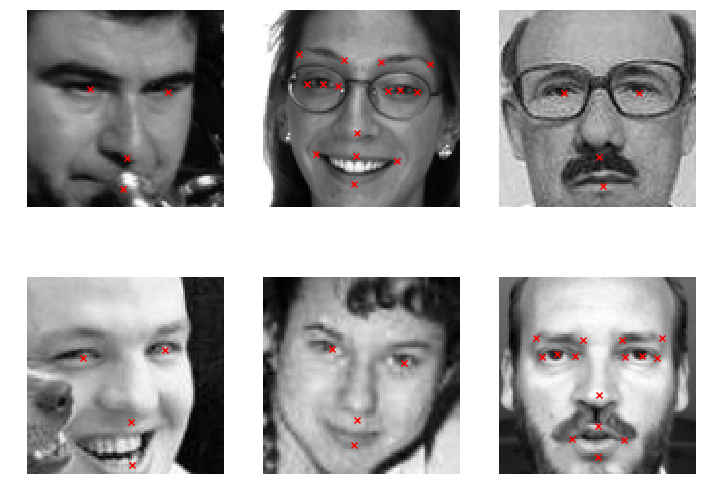

In [14]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data_n[n], self.train_labels_n[n], legend=False) 

#### Plot Examples From Complete Labels

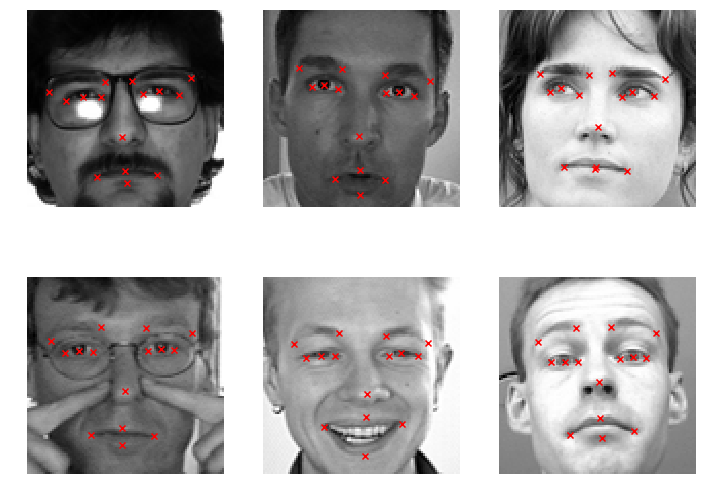

In [15]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data[n], self.train_labels[n], legend=False) 

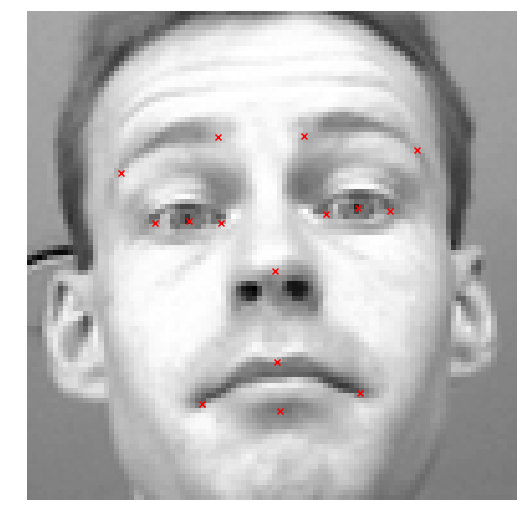

In [16]:
self.plot_example(self.train_data[n], self.train_labels[n], legend=False)

## Feature Engineering

### Blurring the Image

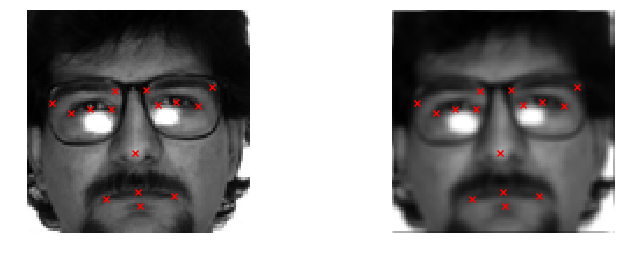

In [32]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data[1], self.train_labels[1], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.blur_data(self.train_data)[1], self.train_labels[1], legend=False)

### Filling Missing Labels

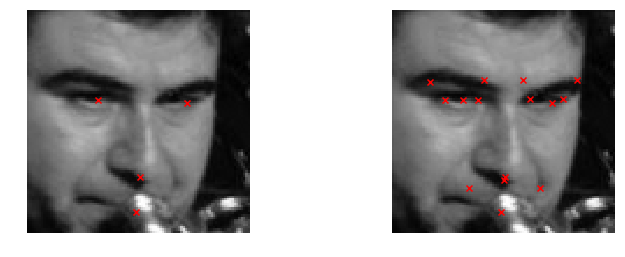

In [18]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data_n[1], self.train_labels_n[1], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.train_data_n[1], self.average_nans(self.train_labels_n)[1], legend=False)

### Flipping the Image

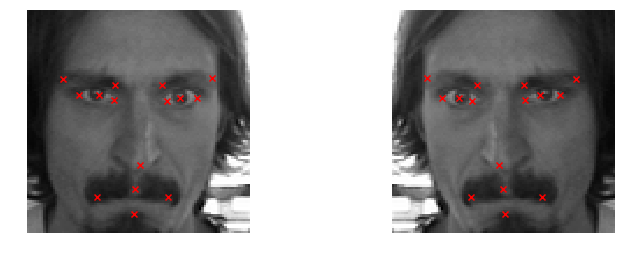

In [19]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data[0], self.train_labels[0], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.train_data_f[0], self.train_labels_f[0], legend=False)

## K-NN

#### Using only the training data with complete set of labels

We used GridSearch to determine that the optimal value for n_neighbors=3

In [20]:
data = self.train_data
labels = self.train_labels

print 'Our training set is size ' + str(data.shape[0])

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

SyntaxError: invalid syntax (<ipython-input-20-c1118233abc9>, line 4)

#### Using training data with missing Labels filled by average

In [ ]:
data = self.train_data_n
labels = self.average_nans(self.train_labels_n)

print 'Our training set is size ' + str(data.shape[0])

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

#### Using blurring and average _nans_

blur_data shifts the image 1 pixel in each direction and takes the mean, effectively returning a blurred image

average_nans replaces missing values/nans with the average value of that feature

In [22]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

print 'Our training set now has increased to ' + str(data.shape[0])

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

SyntaxError: invalid syntax (<ipython-input-22-902e92b8b65e>, line 4)

#### RMSE by Label

In [13]:
pd.DataFrame(np.sqrt(mean_squared_error(self.dev_labels, y_pred, multioutput='raw_values')), 
             columns=['RMSE'], index=self.label_names).sort_values('RMSE', ascending=False)

,RMSE
nose_tip_y,3.024229
mouth_center_bottom_lip_y,2.605217
mouth_center_top_lip_y,2.578482
mouth_left_corner_y,2.394495
mouth_right_corner_y,2.289124
mouth_left_corner_x,2.178618
mouth_right_corner_x,2.149628
right_eyebrow_outer_end_y,2.147477
left_eyebrow_outer_end_y,2.087928
left_eyebrow_outer_end_x,1.898402


#### Plot a Prediction

RMSE of 1.06332539756


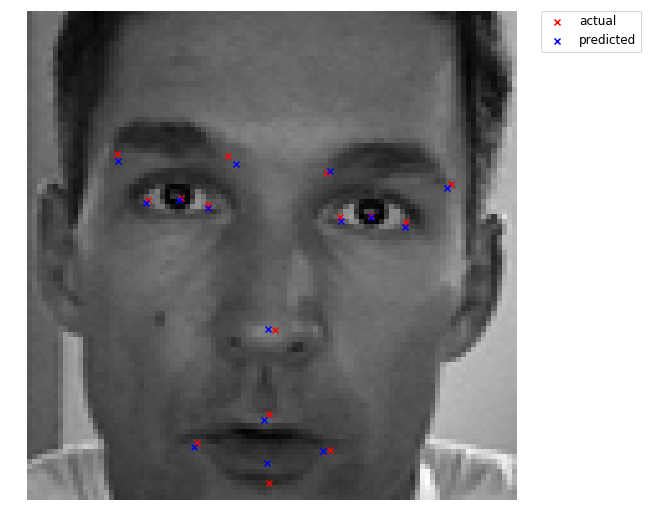

In [14]:
example_num = 25
print ('RMSE of '+ str((self.score(self.dev_labels[example_num], y_pred[example_num]))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], y_pred[example_num])

#### Using Flipped Images to Extend Our Training Data

In [15]:
data = np.concatenate((self.train_data, self.train_data_f))
labels = np.concatenate((self.train_labels, self.train_labels_f))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

print 'RMSE on Dev Data of '
y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

9.8495491412724334

## Neural Net

#### Standard Scale Training and Labels

To start, we trained only on the completely labeled examples with two hidden layers (1000, 500)

We used early_stopping to make training faster and also to avoid overfitting

In [16]:
data = self.train_data
labels = self.train_labels

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True, verbose=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))

Iteration 1, loss = 8.28682371
Validation score: -6.559384
Iteration 2, loss = 2.88234829
Validation score: -2.861513
Iteration 3, loss = 1.73787767
Validation score: -1.564985
Iteration 4, loss = 1.15248183
Validation score: -1.568344
Iteration 5, loss = 0.95069863
Validation score: -0.829381
Iteration 6, loss = 0.77931894
Validation score: -0.562064
Iteration 7, loss = 0.62228628
Validation score: -0.283144
Iteration 8, loss = 0.47440983
Validation score: -0.150297
Iteration 9, loss = 0.45822266
Validation score: 0.060078
Iteration 10, loss = 0.34545572
Validation score: 0.035442
Iteration 11, loss = 0.30444523
Validation score: 0.100070
Iteration 12, loss = 0.27998862
Validation score: 0.185122
Iteration 13, loss = 0.23151991
Validation score: 0.221991
Iteration 14, loss = 0.21651836
Validation score: 0.249486
Iteration 15, loss = 0.21049740
Validation score: 0.289399
Iteration 16, loss = 0.18903588
Validation score: 0.188575
Iteration 17, loss = 0.20356314
Validation score: 0.16739

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [17]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
print 'RMSE on Dev Data of '
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

RMSE on Dev Data of 


2.5982152410568102

#### Using training data with missing Labels filled by average

In [18]:
data = self.train_data_n
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
print 'RMSE on Dev Data of '
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

RMSE on Dev Data of 


2.6057259423783972

#### Using blurring and average _nans_

In [25]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp_blurr = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp_blurr.fit(data_scaler.transform(data), label_scaler.transform(labels))   

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [38]:
y_pred = mlp_blurr.predict(data_scaler.transform(self.dev_data))
print 'RMSE on Dev Data of '
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

RMSE on Dev Data of 


2.3708540709501182

#### Parameter Optimization

In [34]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

# build the regressor
mlp = MLPRegressor(hidden_layer_sizes=(80, 80), activation='relu', solver='sgd', alpha=0.0001, batch_size='auto', 
             learning_rate='constant', learning_rate_init=0.001, max_iter=200, shuffle=True, 
             random_state=None, tol=0.001, verbose=False, early_stopping=True)

# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"hidden_layer_sizes": [(80,80), (90,90), (100,100)],
              "learning_rate_init": [0.00010, 0.00012]}

# run grid search
grid_search = GridSearchCV(mlp, param_grid=param_grid, n_jobs=-1, verbose = 0)
start = time.time()
grid_search.fit(data_scaler.transform(data), label_scaler.transform(labels))

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)




Process ForkPoolWorker-20:
Process ForkPoolWorker-23:
Process ForkPoolWorker-17:
Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-24:
Process ForkPoolWorker-22:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()

KeyboardInterrupt: 

#### Fit, Predict, and Score Using Optimized Parameter Model

In [ ]:
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

y_pred = mlp.predict(data_scaler.transform(self.dev_data))
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

#### Plot a Prediction

RMSE of 2.68375498658


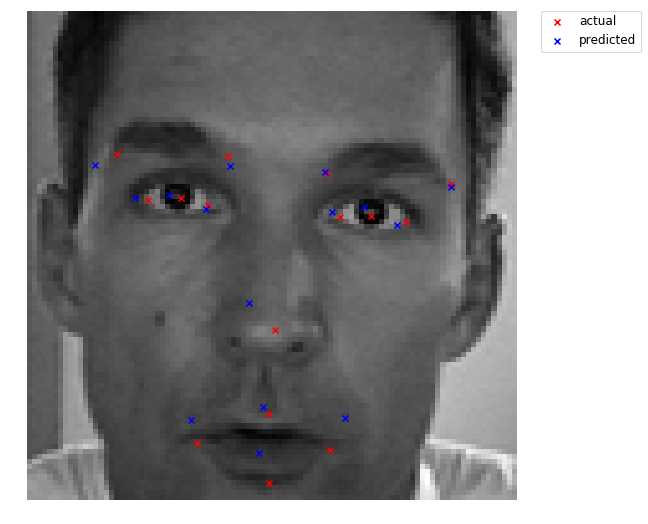

In [22]:
print ('RMSE of '+ str((self.score(self.dev_labels[example_num],
                                   label_scaler.inverse_transform(y_pred[example_num])))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], 
                  label_scaler.inverse_transform(y_pred[example_num]))

#### Examining our Learning Curves

In the above MLP Regression we have the following Learning Curve

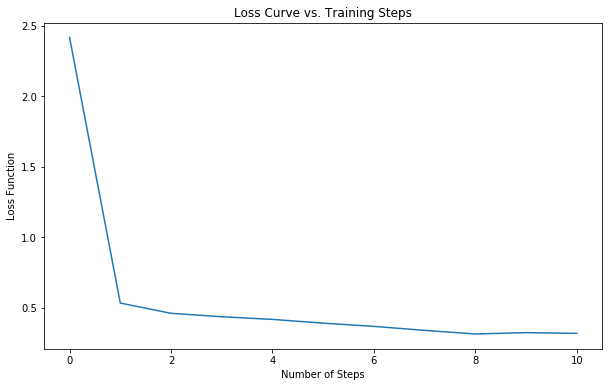

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve vs. Training Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Loss Function')

#### Let's examine a bit closer the Learning Curve using train_test_split

In [24]:
def plot_learning_curves(model, X, y, epoch_size=100):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, X_train.shape[0]/epoch_size):
        model.fit(X_train[:m*epoch_size], y_train[:m*epoch_size])
        y_train_predict = model.predict(X_train[:m*epoch_size])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m*epoch_size]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
        print 'Training Epoch ' + str(m*epoch_size)
        
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='Training Set')
    plt.plot(np.sqrt(val_errors),    'b-', linewidth=3, label='Validation Set')
    plt.title('Loss Curve vs. Training Steps')
    plt.xlabel('Number of Steps')
    plt.ylabel('Loss Function')
    plt.legend()
    return

Training Epoch 50
Training Epoch 100
Training Epoch 150
Training Epoch 200
Training Epoch 250
Training Epoch 300
Training Epoch 350
Training Epoch 400
Training Epoch 450
Training Epoch 500
Training Epoch 550
Training Epoch 600
Training Epoch 650
Training Epoch 700
Training Epoch 750
Training Epoch 800
Training Epoch 850


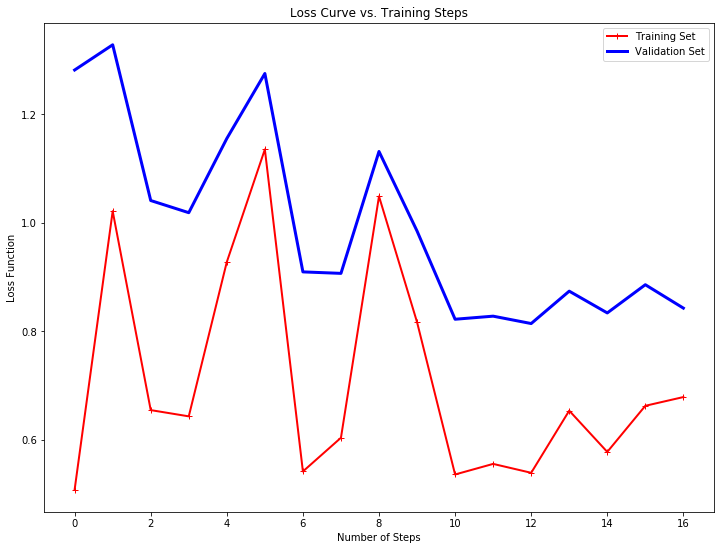

In [25]:
data = self.train_data
labels = self.train_labels

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)

## Warning this can be very slow depending on epoch_size and training data size!!
plot_learning_curves(mlp, data_scaler.transform(data), label_scaler.transform(labels), epoch_size=50)

#### Using Flipped Images to Extend Our Training Data

Flipping the image makes the RMSE worse!

In [26]:
data = np.concatenate((self.train_data, self.train_data_f))
labels = np.concatenate((self.train_labels, self.train_labels_f))

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [27]:
print 'RMSE on Dev Data of '
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

12.373261819164039

## Submissions

In [28]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

k_nn_submission = knn.predict(self.test_data)
self.submission_gen(k_nn_submission, 'knn')

In [29]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

mlp_submission = mlp.predict(data_scaler.transform(self.test_data))
self.submission_gen(label_scaler.inverse_transform(mlp_submission), 'mlp')

## Appendix

## Grid Search to Find Best Parameters

In [30]:
knn = KNeighborsRegressor()
parameters ={'n_neighbors': range(1, 25)}

## Warning Slow
# clf = GridSearchCV(knn, parameters)
# clf.fit(self.train_data, self.train_labels)
# clf.best_params_

In [31]:
mlp = MLPRegressor()

parameters = {'hidden_layer_sizes': [(500, 200), (1000, 500), (300, 100), (500, 300, 100)],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'alpha': [0.0001, 0.001, 0.01, 0.005],
              'learning_rate': ['constant', 'adaptive'],
              'learning_rate_init': [0.001, 0.005, 0.01, 0.0001],
              'early_stopping': ['True']
              }


## Warning this is VERY SLOW
# clf = GridSearchCV(mlp, parameters)
# clf.fit(self.train_data, self.train_labels)
# clf.best_params_

## Having Some Fun!

In [27]:
im = imageio.imread('harry.jpg')

OSError: No such file: '/Users/noah/Documents/W207_Machine_Learning/Group_Project/harry.jpg'

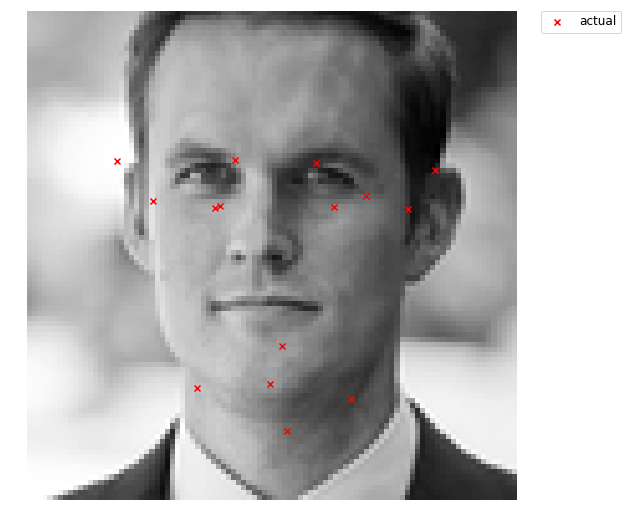

In [28]:
harry_labels_mlp = mlp_blurr.predict(data_scaler.transform(self.rgb2gray(im).reshape(1, 9216)/255.0))
self.plot_example(self.rgb2gray(im)/255.0, label_scaler.inverse_transform(harry_labels_mlp).flatten())